# Лабораторная работа №4
Выполнила Карасева Екатерина M33351

## Наивный байесовский классификатор

In [40]:
import glob
import pandas as pd
import numpy as np


def main():
    table = [read_package(i) for i in range(1, 11)]
    n_grams = [1, 2, 3]
    alphas = [1e-3, 1e-4, 1e-5, 1e-6, 1e-10]
    results = {'accuracy': [], 'n': [], 'alpha': []}
    for n in n_grams:
        table_ngram = list(map(lambda pack: list(map(lambda file: get_ngrams(file, n), pack)), table))
        for alpha in alphas:
            accuracy, _ = kfold(table_ngram, alpha, [1, 0])
            results['accuracy'].append(accuracy)
            results['n'].append(n)
            results['alpha'].append('{:.0e}'.format(alpha))
    results = pd.DataFrame.from_dict(results)
    results = results.sort_values(by=['accuracy'], ascending=False)
    return results


def read_package(index):
    root = 'messages'
    dataset = []
    path = '{}/part{}'.format(root, index)
    for filename in glob.glob('{}/*.txt'.format(path)):
        y = int('spm' in filename)
        message = parse_file(filename)
        dataset.append((message, y))
    return dataset


def parse_file(filename):
    f = open(filename, 'r')
    subject = list(map(int, f.readline().split()[1:]))
    f.readline()
    message = list(map(int, f.readline().split()))
    return {'subject': subject, 'message': message}


def get_ngrams(file, n):
    return set(process_grams(file[0]['subject'], n) + process_grams(file[0]['message'], n)), file[1]


def process_grams(a, n):
    indices = [i for i in range(len(a) + 1 - n)]
    grams = list(map(lambda ind: a[ind:(ind + n)], indices))
    return list(map(map_gram, grams))


def map_gram(g):
    multiplier = 1
    result = 0
    for i in range(len(g)):
        result += g[i] * multiplier
        multiplier *= 100000
    return result


def kfold(table, alpha, logged_lambdas=[0, 0]):
    accuracies = []
    cnt = 0
    for i in range(0, 10):
        train = []
        for j in range(0, 10):
            if j != i:
                train += table[j]
        test = table[i]
        prediction = bayes_classifier(train, test, alpha, logged_lambdas)
        test_acc, cnt_false_legit = get_acc(prediction)
        cnt += cnt_false_legit
        accuracies.append(test_acc)
    return np.mean(accuracies), cnt


def bayes_classifier(train, test, alpha=1e-10, logged_lambdas=[0, 0]):
    train_size = len(train)
    count = [{}, {}]
    classes_counter = [0, 0]
    words_set = set()

    for i in range(train_size):
        message, y = train[i]
        classes_counter[y] += 1
        for word in message:
            words_set.add(word)
            if word not in count[y]:
                count[y][word] = 0
            count[y][word] += 1

    prior_prob = list(map(lambda x: x / train_size, classes_counter))
    p = [
        {w: np.log(calc_p(count[c].get(w, 0), classes_counter[c], alpha)) for w in words_set}
        for c in range(2)
    ]
    rev_p = [
        {w: np.log(1 - calc_p(count[c].get(w, 0), classes_counter[c], alpha)) for w in words_set}
        for c in range(2)
    ]
    precalced_sum = [np.sum([rev_p[c][w] for w in words_set]) for c in range(2)]

    test_size = len(test)
    test_results = []
    for i in range(test_size):
        message, target = test[i]
        results = [logged_lambdas[c] + np.log(prior_prob[c]) + precalced_sum[c] for c in range(2)]
        for c in range(2):
            for w in message:
                results[c] -= rev_p[c].get(w, 0)
                results[c] += p[c].get(w, 0)
        predicted = np.argmax(results)
        normalized = np.divide(results, np.linalg.norm(results))
        test_results.append((predicted, target, normalized))
    return test_results


def calc_p(count_x, counter, alpha, q=2):
    return (count_x + alpha) / (counter + alpha * q)


def get_acc(results):
    true = 0
    cnt_false_legit = 0
    for i in range(len(results)):
        predicted, target, _ = results[i]
        true += (predicted == target)
        if target == 0 and predicted == 1:
            cnt_false_legit += 1
    return true / (len(results)), cnt_false_legit

In [41]:
res = main()
res

,accuracy,n,alpha
9,0.977064,2,1e-10
4,0.970642,1,1e-10
8,0.969725,2,1e-06
2,0.967890,1,1e-05
3,0.967890,1,1e-06
1,0.966055,1,1e-04
7,0.964220,2,1e-05
14,0.960550,3,1e-10
0,0.958716,1,1e-03
6,0.955046,2,1e-04


In [42]:
from matplotlib import pyplot as plt

def draw_roc():
    n = 2
    table = [read_package(i) for i in range(1, 11)]
    table = list(map(lambda pack: list(map(lambda file: get_ngrams(file, n), pack)), table))
    all_results = []
    for i in range(0, 10):
        train = []
        for j in range(0, 10):
            if j != i:
                train += table[j]
        test = table[i]
        prediction = bayes_classifier(train, test)
        all_results += prediction

    # Probability, predicted, target
    all_results = list(map(lambda a: (a[2][1], a[0], a[1]), all_results))
    all_results.sort(reverse=True)

    spams = len(list(filter(lambda a: a[2] == 1, all_results)))
    legits = len(all_results) - spams

    x, y = [0], [0]
    for _, predicted, target in all_results:
        if target == 1:
            x.append(x[-1])
            y.append(y[-1] + (1 / spams))
        else:
            x.append(x[-1] + (1 / legits))
            y.append(y[-1])

    plt.plot(x, y)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

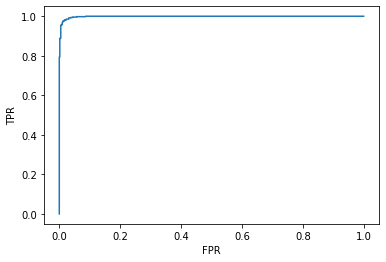

In [43]:
draw_roc()

In [44]:
def draw_plot():
    n = 2
    alpha = 1e-10
    table = [read_package(i) for i in range(1, 11)]
    table = list(map(lambda pack: list(map(lambda file: get_ngrams(file, n), pack)), table))

    x = []
    y = []
    l = 0
    while True:
        score, cnt = kfold(table, alpha, [l, 0])
        x.append(l)
        y.append(score)
        if cnt == 0 or l > 3000:
            print(l)
            print(score)
            break
        l += 100
    plt.plot(x, y)
    plt.xlabel('ln(λ.legit)')
    plt.ylabel('accuracy')
    plt.show()

1100
0.8073394495412846


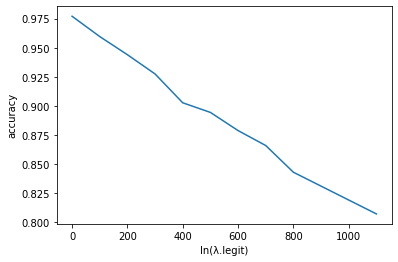

In [45]:
draw_plot()
